### Functions to use

In [1]:
# Importing libraries

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Literal, Union, List
import os

In [8]:
# Auxiliary functions

def edges_with_degrees(graph: nx.Graph, deg1: int, deg2: int) -> float:
    counter = 0
    
    for v,w in graph.edges:
        if {graph.degree[v], graph.degree[w]} == {deg1, deg2}:
            counter += 1
    
    return counter

In [9]:
# Definition of energy

# Returns the energy of a graph
def energy(graph: nx.Graph) -> float:
    """ Returns the energy of a graph

    Args:
        graph (nx.Graph): Graph to get the energy from

    Returns:
        float: Energy of the graph
    """
    
    # Obtain the adjacency matrix of the graph
    adj_mat = nx.adjacency_matrix(graph).todense()
    # Compute the eigenvalues of the adjacency matrix of the graph
    eigs = np.linalg.eigvals(adj_mat)

    # Compute the energy of the graph
    return np.sum(np.abs(eigs))

In [10]:
# Local bounds for the energy graph

def ariz_juarez_bound(graph: nx.graph) -> float:
    """ Compute the Arizmendi-Juarez bound for the energy of a graph

    Args:
        graph (nx.graph): Graph to compute the the Arizmendi-Juarez bound

    Returns:
        float: Arizmendi-Juarez bound for the energy of the graph
    """
    
    # Obtain the vector of degrees of the graph
    degrees = np.array([deg for (_, deg) in graph.degree()])
    
    # Return the Arizmendi-Juarez bound for the energy of the graph
    return np.sum(np.sqrt(degrees))

def ariz_dom_bound(tree: nx.Graph) -> float:
    """ Calculate the Arizmendi-Dominguez bound for the energy of a tree

    Args:
        tree (nx.Graph): Tree to calculate the Arizmendi-Dominguez bound

    Returns:
        float: Arizmendi-Dominguez bound for the energy of the tree
    """
    
    # If the graph is not a tree then return -1
    #if not nx.is_tree(tree):
    #    return -1
    
    # Obtain the vector of degrees of the tree
    degrees = np.array([deg for (_, deg) in tree.degree()])
    # Sort the degrees vector
    np.ndarray.sort(degrees)
    
    # Sum 1 to the greatest degree for calculate the bound conveniently
    degrees[-1] += 1
    
    # Return the Arizmendi-Dominguez bound for the energy of the tree
    return 2 * np.sum(np.sqrt(degrees - 1))

def ariz_dom_bound2(tree: nx.Graph) -> float:
    """ Calculate the Arizmendi-Dominguez bound for the energy of a tree
        using an improved bound

    Args:
        tree (nx.Graph): Tree to calculate the Arizmendi-Dominguez bound

    Returns:
        float: Arizmendi-Dominguez bound for the energy of the tree
    """
    
    # If the graph is not a tree then return -1
    #if not nx.is_tree(tree):
    #    return -1
    
    # Obtain the vector of degrees of the tree
    degrees = np.array([deg for (_, deg) in tree.degree()])
    # Sort the degrees vector
    np.ndarray.sort(degrees)
    
    # Sum 1 to the greatest degree for calculate the bound conveniently
    degrees[-1] += 1
    
    # Number of edges with both endpoints of degrees 2
    e22 = edges_with_degrees(tree, 2, 2)
    
    # Return the Arizmendi-Dominguez bound for the energy of the tree
    return 2 * np.sum(np.sqrt(degrees - 1)) - e22 * (4 - np.sqrt(8)) / 3

def deg_leaves_bound(graph: nx.Graph) -> float:
    """ Compute a bound for the energy of a graph using the degrees
        and the number of leaves atached to each node

    Args:
        graph (nx.Graph): Graph to compute the bound in terms of
        degrees and leaves

    Returns:
        float: Bound for the energy of the graph using degrees and leaves
    """
    
    # Variable to storage the bound
    bound = 0
    
    for v in graph.nodes():        
        # Obtain the degree of the node
        deg = graph.degree[v]
        
        # If the node is a leaf or an isolated node, we skip it
        if deg <= 1:
            continue
        
        # Obtain the number of leaves attached to the node
        leaves = sum(1 for w in graph[v] if graph.degree[w] == 1)
        
        # Add the term asociated to this vertex:
        # sqaure root of three times the number of leaves plus the degree
        bound += np.sqrt(3 * leaves + deg)
    
    # Obtain the number of edges with both endpoints being leaves
    e11 = edges_with_degrees(graph, 1, 1)
    
    return 2 * e11 + bound

In [11]:
# Global bounds for the energy graph

def mcclelland_bound(graph: nx.Graph) -> float:
    """ Calculate the McClelland bound for the energy of a graph

    Args:
        graph (nx.Graph): Graph to calculate the McClelland's bound

    Returns:
        float: McClelland bound for the energy of the graph
    """
    
    # Obtain the number of nodes in the graph
    num_nodes = graph.number_of_nodes()
    # Obtain the number of edges in the graph
    num_edges = graph.number_of_edges()
    # Calculate the number of isolated nodes in the graph
    num_isolated_nodes = sum(1 for _, d in graph.degree() if d == 0)
    
    # Return the McClelland bound for the energy of the graph
    return np.sqrt(2 * (num_nodes - num_isolated_nodes) * num_edges)

def global_deg_leaves_bound(graph: nx.Graph) -> float:
    """ Calculate the global bound for the energy of a graph in terms of
        of degrees and leaves. It use the number of, nodes, number of edges,
        number of leaves, and number of edges with both endpoints being leaves    

    Args:
        graph (nx.Graph): Graph to calculate the global bound in terms of
        degrees and leaves

    Returns:
        float: Global bound for the energy of the graph using degrees and leaves
    """
    
    # Calcultate de number of nodes in the graph
    num_nodes = graph.number_of_nodes()
    # Calculate the number of edges in the graph
    num_edges = graph.number_of_edges()
    # Calculate the number of leaves in the graph
    num_leaves = sum(1 for _, d in graph.degree() if d == 1)
    # Calculate the number of isolated nodes in the graph
    num_isolated_nodes = sum(1 for _, d in graph.degree() if d == 0)
    # Calculate the number of edges with both endpoints being leaves
    e11 = edges_with_degrees(graph, 1, 1)
    
    # Return the global bound for the energy of the graph using degrees and leaves
    return 2 * e11 + np.sqrt(2 * (num_nodes - num_leaves - num_isolated_nodes) * (num_edges + num_leaves - 3 * e11))

In [6]:
# Functions for asymptotic bounds

# Constant of asymptotic bound for normalized energy of graphs following Barabassi-Albert model
BARABASSI_ALBERT_ASYMP_BOUND = 0.96

def asymptotic_bound_Erdos_Renyi(lbd: float, tolerance: float = 0.0000001) -> float:
    aux1 = np.exp(-lbd)
    aux2 = np.sqrt(3 * aux1 + 1)
    power_factorial = lbd ** 2 / 2
    k = 2
    
    result = lbd * aux1 ** 2
    term = 1

    while term >= tolerance:
        term = aux1 * aux2 * power_factorial * np.sqrt(k)
        result += term
        
        k += 1
        power_factorial *= lbd / k
        
    error = aux2 * power_factorial
    
    return result + error, k, error

def asymptotic_bound_Erdos_Renyi2(lbd: float) -> float:
    aux1 = np.exp(-lbd)
    aux2 = np.sqrt(3 * aux1 + 1)
    
    return lbd * aux1 ** 2 + aux2 * (lbd + 2 - aux1 * (3 * lbd + 2)) / np.sqrt(8)

In [7]:
# Functions for simulation

def simulate_graphs(num_sim: int, graph_gen: Literal["Erdos-Renyi", "Barabassi-Albert"], num_nodes: int,
                    param: Union[float, None] = None, name_file: str = "") -> None:
    """ Simulate graphs under two types of models to choose (Erdos-Renyi and Barabassi-Albert),
    and saving the energy and different bounds for its energy depending on the chosen model.
    If Erdos-Renyi is chosen, then it is calculated bound given by Arizmendi and Juarez. Otherwise, it
    is calculated bound given by Arizmendi and Dominguez. In both cases, they are calculated the bound
    in terms of degrees and leaves, the McClelland bound and the global bound in terms of degrees and leaves.

    Args:
        num_sim (int): Number of graphs to simulate
        graph_gen (Literal[&quot;Erdos): Model of random graph to choose
        num_nodes (int): Number of nodes of every graph
        param (Union[float, None], optional): _description_. Defaults to None. If Erdos-Renyi was chosen, then a
        value between 0 and 1, the probability of existing an edge, is expected.
        name_file (str, optional): _description_. Defaults to "". Name of file for saving the bounds
        of the simulated graphs.
    """
    
    if graph_gen == "Erdos-Renyi":
        if type(param) != float or param < 0 or 1 < param:
            raise ValueError(f"Param parameter {param} is not a probability!")
            
        else:
            graph_sim = nx.erdos_renyi_graph
            bounds_func = [energy, ariz_juarez_bound, deg_leaves_bound, mcclelland_bound, global_deg_leaves_bound]
    else:
        graph_sim = nx.barabasi_albert_graph
        param = 1
        bounds_func = [energy, ariz_dom_bound, deg_leaves_bound, mcclelland_bound, global_deg_leaves_bound]
        
    if name_file == "":
        name_file = f"{graph_gen}_model_{num_nodes}_nodes_{param}_param_{num_sim}_sim.txt"
        
    for _ in tqdm(range(num_sim)):
        graph = graph_sim(num_nodes, param)
        
        bounds = []
        
        for bound in bounds_func:
            bounds.append(bound(graph))
            
        with open(name_file, "a") as file:
            file.write(f"{' '.join(map(str, bounds))}\n")
    
    return

In [8]:
# Function to create plot of simulations

# Define allowed legend locations
LegendLocation = Literal[
    "best", "upper right", "upper left", "lower left", "lower right",
    "right", "center left", "center right", "lower center", 
    "upper center", "center"
]

def create_plot(name_file: str, num_nodes: int, title: str = "", plot_index: List[int] = None, labels: List[str] = None,
                const: float = None, label_const: str = "", name_fig: str = "", legend_loc: LegendLocation = "",
                save_fig: bool = True, xlabel = "Number of simulation", ylabel = "Bound dived by the number of nodes",
                fontsize = 8, figsize : tuple = (8, 6)) -> None:
    
    if plot_index is None:
        plot_index = np.arange(5)
    
    data = np.loadtxt(name_file) / num_nodes
    num_sim = data.shape[0]
    
    x_axis = np.arange(1, num_sim + 1)
    
    plt.figure(figsize = figsize)
    
    if labels is None:
        for i in plot_index:
            plt.plot(x_axis, data[:, i])
    else:
        if len(labels) < len(plot_index):
            labels += [""] * (len(plot_index) - len(labels))
            
        for i in plot_index:
            plt.plot(x_axis, data[:, i], label = labels[i])
            
    if const is not None:
        if label_const != "":
            plt.hlines(const, x_axis[0], x_axis[-1], color = "r", linestyle = '--', label = label_const)
        else:
            plt.hlines(const, x_axis[0], x_axis[-1], color = "r", linestyle = '--')
            
    if title != "":
        plt.title(title)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if legend_loc == "":
        legend_loc = "upper right"
    
    plt.legend(loc = legend_loc, fontsize = fontsize)
    plt.grid(True)
    
    if save_fig:
        if name_fig == "":
            name_fig = os.path.splitext(name_file)[0] + ".pdf"
            
        plt.savefig(name_fig, bbox_inches = "tight")
        
    plt.show()
    plt.close()
    
    return

### Simulations

#### Barabasi Albert trees

In [ ]:
# Simulating Barabassi-Albert graphs and obtaining the bounds
num_sim = 300
num_nodes = 2000

simulate_graphs(num_sim, 'Barabassi-Albert', num_nodes, 1, '300_BA_simulations_2000_nodes.txt')

  0%|          | 0/300 [00:00<?, ?it/s]

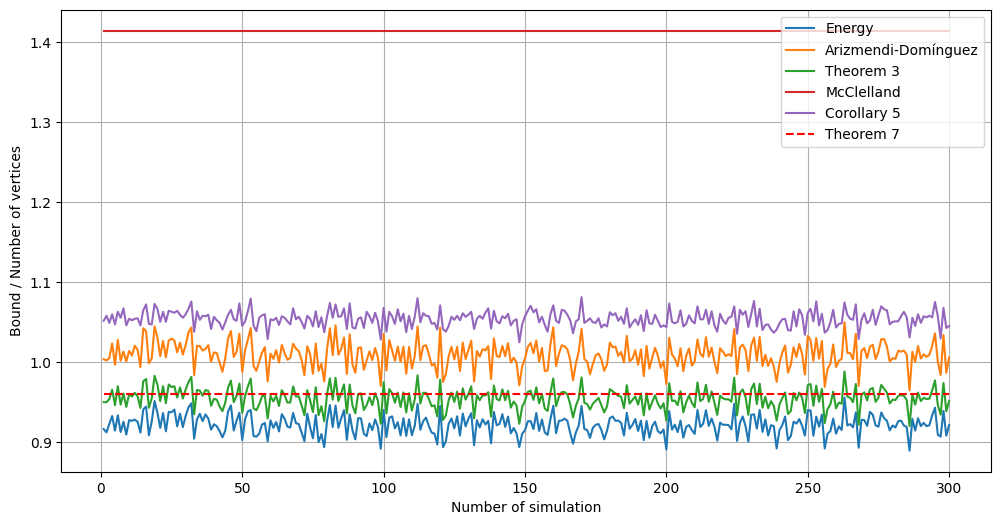

In [9]:
create_plot("300_BA_simulations_2000_nodes.txt", 2000, labels = ["Energy", "Arizmendi-Domínguez", "Theorem 3", "McClelland", "Corollary 5"],
            const = BARABASSI_ALBERT_ASYMP_BOUND, label_const = "Theorem 7", name_fig = "300 BA simulations, n = 2000.pdf",
            ylabel = "Bound / Number of vertices", fontsize = 10, figsize = (12, 6))

#### Erdos Renyi sparce graphs

In [ ]:
# Simulating Erdos-Renyi graphs and obtaining the bounds
num_sim = 100
num_nodes = 2000
lbd = 1.0

simulate_graphs(num_sim, "Erdos-Renyi", num_nodes, lbd / num_nodes)

  0%|          | 0/100 [00:00<?, ?it/s]

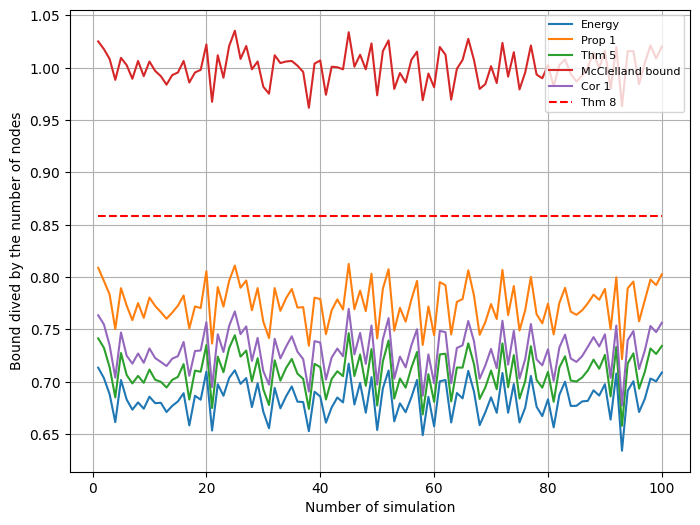

In [125]:
lbd = 1.0
asymptotic_bound, _, _ = asymptotic_bound_Erdos_Renyi(lbd)

create_plot("Erdos-Renyi_model_2000_nodes_0.0005_param_100_sim.txt", 2000, labels = ["Energy", "Prop 1", "Thm 5", "McClelland bound", "Cor 1"],
            const = asymptotic_bound, label_const = "Thm 8", name_fig = "200 ER simulations, n = 2000, lbd = 1.pdf")

In [ ]:
num_sim = 100
num_nodes = 2000
lbd = 2.0

simulate_graphs(num_sim, "Erdos-Renyi", num_nodes, lbd / num_nodes)

  0%|          | 0/100 [00:00<?, ?it/s]

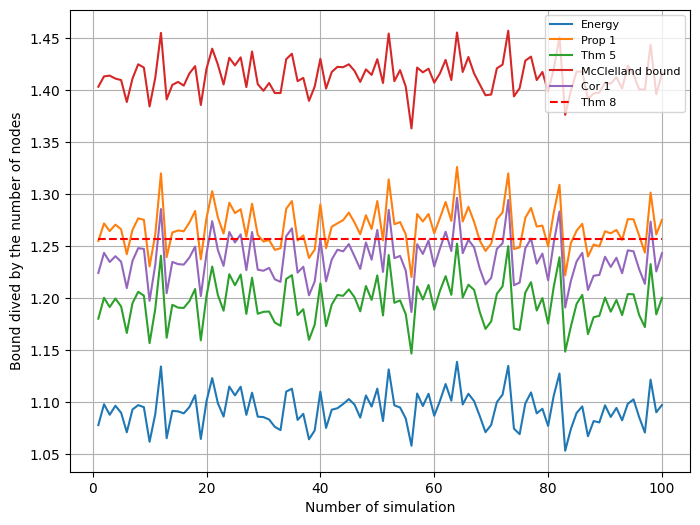

In [ ]:
lbd = 2
asymptotic_bound, _, _ = asymptotic_bound_Erdos_Renyi(lbd)

create_plot("Erdos-Renyi_model_2000_nodes_0.001_param_100_sim.txt", 2000, labels = ["Energy", "Prop 1", "Thm 5", "McClelland bound", "Cor 1"],
            const = asymptotic_bound, label_const = "Thm 8", name_fig = "200 ER simulations, n = 2000, lbd = 2.pdf")

In [ ]:
num_sim = 300
num_nodes = 2000
lbd = 4/3

simulate_graphs(num_sim, "Erdos-Renyi", num_nodes, lbd / num_nodes, name_file = '300_ER_simulations_2000_nodes_4_3_param.txt')

  0%|          | 0/300 [00:00<?, ?it/s]

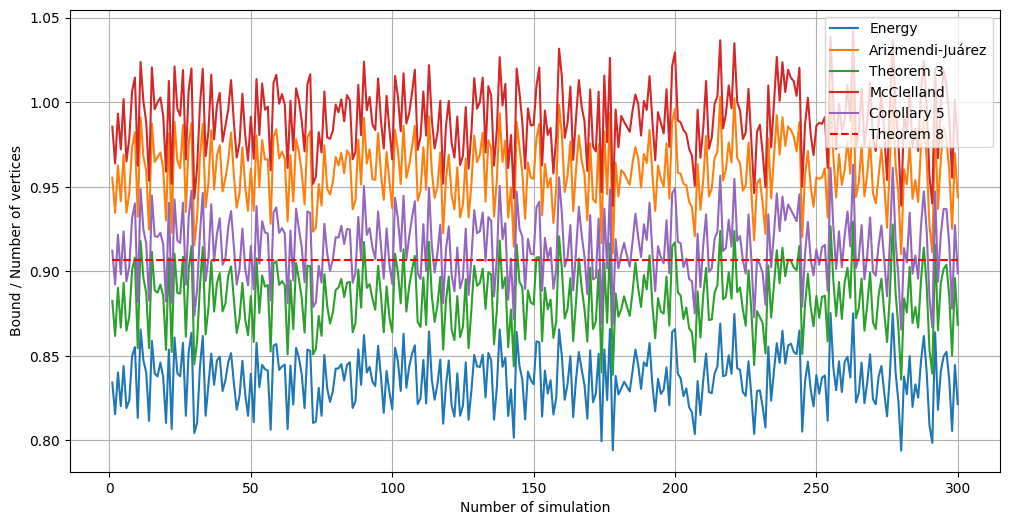

In [10]:
lbd = 4/3
asymptotic_bound, _, _ = asymptotic_bound_Erdos_Renyi(lbd)

create_plot("300_ER_simulations_2000_nodes_4_3_param.txt", 2000, labels = ["Energy", "Arizmendi-Juárez", "Theorem 3", "McClelland", "Corollary 5"],
            const = asymptotic_bound, label_const = "Theorem 8", name_fig = "300 ER simulations, n = 2000, lbd = 4-3.pdf",
            ylabel = "Bound / Number of vertices", fontsize = 10, figsize = (12, 6))

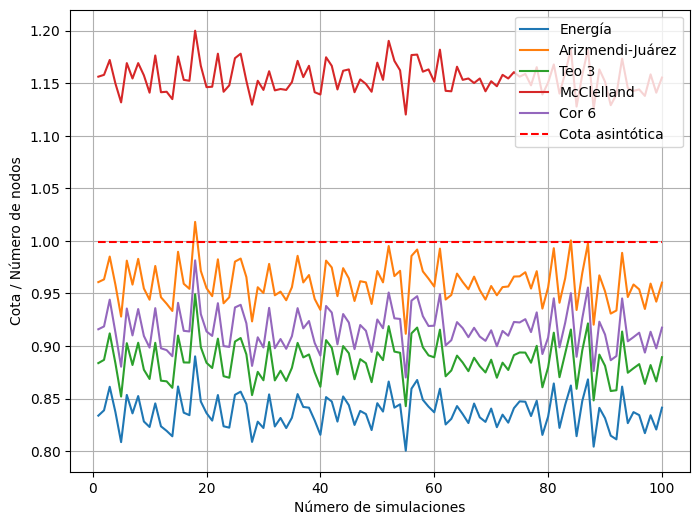

In [13]:
lbd = 4/3
asymptotic_bound, _, _ = asymptotic_bound_Erdos_Renyi(lbd)

create_plot("100_ER_simulations_2000_nodes_4_3.txt", 2000, labels = ["Energía", "Arizmendi-Juárez", "Teo 3", "McClelland", "Cor 6"],
            const = asymptotic_bound, label_const = "Cota asintótica", name_fig = "200 simulaciones ER, n = 2000, lbd = 4-3.pdf",
            xlabel = "Número de simulaciones", ylabel = "Cota / Número de nodos", fontsize = 10)

In [9]:
import math

num_sim = 300
num_nodes = 2000
lbd = math.log(num_nodes)

simulate_graphs(num_sim, "Erdos-Renyi", num_nodes, lbd / num_nodes, name_file = "300 simulaciones caso critico ER.txt")

  0%|          | 0/300 [00:00<?, ?it/s]

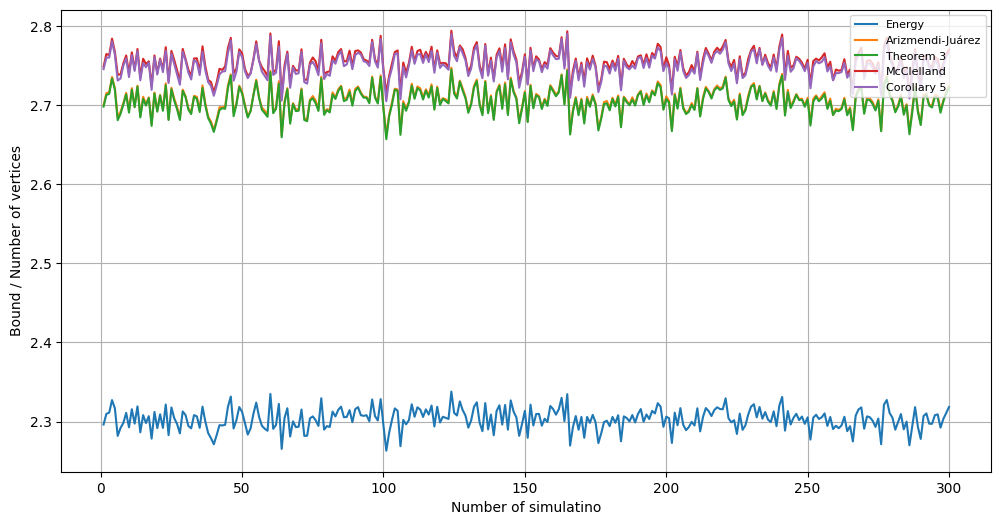

In [10]:
num_nodes = 2000
lbd = math.log(num_nodes)

#asymptotic_bound, _, _ = asymptotic_bound_Erdos_Renyi(lbd)

create_plot("300 simulaciones caso critico ER.txt", 2000, labels = ["Energy", "Arizmendi-Juárez", "Theorem 3", "McClelland", "Corollary 5"],
            name_fig = "300 simulaciones ER, n = 2000, lbd = log(n).pdf",
            xlabel = "Number of simulatino", ylabel = "Bound / Number of vertices", figsize = (12, 6))

#### Comparation between asymptotic bounds for Erdos-Renyi model

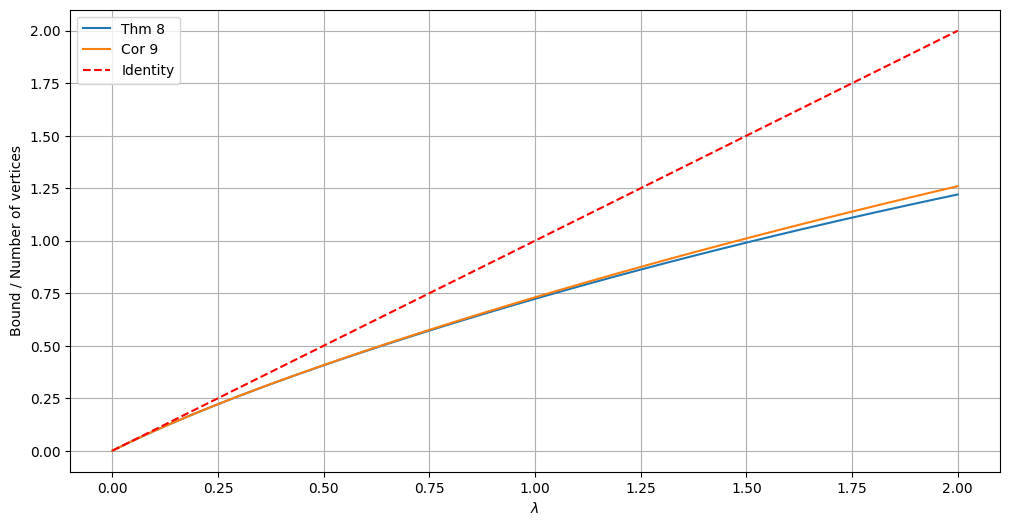

In [14]:
x_axis = np.linspace(0, 2, 100)

y_axis1 = [asymptotic_bound_Erdos_Renyi(lbd)[0] for lbd in x_axis]
y_axis2 = [asymptotic_bound_Erdos_Renyi2(lbd) for lbd in x_axis]

plt.figure(figsize=(12, 6))
plt.plot(x_axis, y_axis1, label = "Thm 8")
plt.plot(x_axis, y_axis2, label = "Cor 9")
plt.plot(x_axis, x_axis, c = "r", linestyle = "--", label = "Identity")

plt.xlabel(r"$\lambda$")
plt.ylabel("Bound / Number of vertices")

plt.legend()
plt.grid(True)

plt.savefig("ER cota suma vs explicita.pdf")

plt.show()